In [206]:
from sodapy import Socrata
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import time
import retrieval_311

In [207]:
df = pd.read_csv('data/processed_data.csv')
df = df.drop(labels=df.keys()[0], axis=1)
df['datetime'] = pd.to_datetime(df['datetime'],format="%Y-%m-%d")
df = df[(df['datetime'].dt.year > 2008) & (df['datetime'].dt.year < 2023)]

In [208]:
full_hourly_count = df.copy()
full_hourly_count.columns = ['Hours', 'CaseID', 'Month', 'Day', 'Day_Month', 'Hour']
full_hourly_count['Year'] = full_hourly_count['Hours'].dt.year
full_hourly_count

,Hours,CaseID,Month,Day,Day_Month,Hour,Year
4416,2009-01-01 00:00:00,0,1,3,1,0,2009
4417,2009-01-01 01:00:00,0,1,3,1,1,2009
4418,2009-01-01 02:00:00,0,1,3,1,2,2009
4419,2009-01-01 03:00:00,0,1,3,1,3,2009
4420,2009-01-01 04:00:00,0,1,3,1,4,2009
...,...,...,...,...,...,...,...
127123,2022-12-31 19:00:00,6,12,5,31,19,2022
127124,2022-12-31 20:00:00,3,12,5,31,20,2022
127125,2022-12-31 21:00:00,8,12,5,31,21,2022
127126,2022-12-31 22:00:00,6,12,5,31,22,2022


In [209]:
# normalize the data by year
# Clipping outliers outside of 3 standard deviations for each year
# saving a list of scalers to inverse forecasted data

normalized_data_array = []
scaler_list = []
for year in np.unique(full_hourly_count['Year']):
    scaler = StandardScaler()
    curr_year_data = full_hourly_count[full_hourly_count['Year']==year]['CaseID'].values
    curr_std = curr_year_data.std()
    clipped_curr_year_data = np.array([x if np.abs(x) < 3*curr_std else 3*curr_std for x in curr_year_data])
    normalized_data = scaler.fit_transform(clipped_curr_year_data.reshape(-1,1)).reshape(-1)
    normalized_data_array.append(normalized_data)
    scaler_list.append(scaler)
    
scaler_dict = {'scaler': scaler_list}
full_hourly_count['CaseID_norm'] = np.hstack(normalized_data_array)
full_hourly_count

,Hours,CaseID,Month,Day,Day_Month,Hour,Year,CaseID_norm
4416,2009-01-01 00:00:00,0,1,3,1,0,2009,-0.965170
4417,2009-01-01 01:00:00,0,1,3,1,1,2009,-0.965170
4418,2009-01-01 02:00:00,0,1,3,1,2,2009,-0.965170
4419,2009-01-01 03:00:00,0,1,3,1,3,2009,-0.965170
4420,2009-01-01 04:00:00,0,1,3,1,4,2009,-0.965170
...,...,...,...,...,...,...,...,...
127123,2022-12-31 19:00:00,6,12,5,31,19,2022,-0.884812
127124,2022-12-31 20:00:00,3,12,5,31,20,2022,-0.984097
127125,2022-12-31 21:00:00,8,12,5,31,21,2022,-0.818623
127126,2022-12-31 22:00:00,6,12,5,31,22,2022,-0.884812


## ARIMA

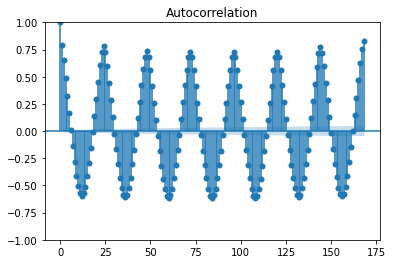

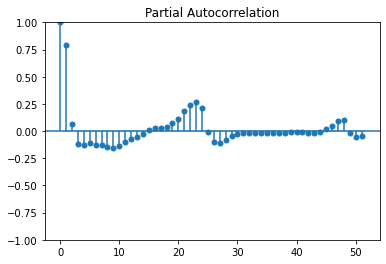

In [210]:
plot_acf(full_hourly_count['CaseID_norm'].values.astype(float), lags=168, alpha=0.05)
plt.savefig('figures/ARIMA_autocorrelation', dpi=300)
plot_pacf(full_hourly_count['CaseID_norm'].values.astype(float), method='ywm')
plt.savefig('figures/ARIMA_partial_autocorrelation', dpi=300)
plt.show();

### 2021 predict 2022 tune hyperparameters

In [211]:
data_2021 = full_hourly_count[full_hourly_count['Year']==2021]
data_2021

data_2022 = full_hourly_count[full_hourly_count['Year']==2022]
data_2022

,Hours,CaseID,Month,Day,Day_Month,Hour,Year,CaseID_norm
118368,2022-01-01 00:00:00,4,1,5,1,0,2022,-0.951002
118369,2022-01-01 01:00:00,8,1,5,1,1,2022,-0.818623
118370,2022-01-01 02:00:00,1,1,5,1,2,2022,-1.050286
118371,2022-01-01 03:00:00,1,1,5,1,3,2022,-1.050286
118372,2022-01-01 04:00:00,11,1,5,1,4,2022,-0.719339
...,...,...,...,...,...,...,...,...
127123,2022-12-31 19:00:00,6,12,5,31,19,2022,-0.884812
127124,2022-12-31 20:00:00,3,12,5,31,20,2022,-0.984097
127125,2022-12-31 21:00:00,8,12,5,31,21,2022,-0.818623
127126,2022-12-31 22:00:00,6,12,5,31,22,2022,-0.884812


In [216]:
def tune_arima_hyperparams(data, forecast_length, p, d):
    '''
    Inputs:
        data
        p - max order of autoregressive model to evaluate
        d - max degree of differencing to evaluate
    Outputs:
        aic_array - numpy array of maic of each model evaluated
        mse_array - numpy array of mse of each model evaluated
        optimal_order - tuple, values of p,d,q that resulted in lowest mse
        forecast - 
    '''
    aic_array = np.ones((p,d))
    mse_array = np.ones((p,d))
    order_array = []
    for i in range(p):
        for j in range(d):
            model = ARIMA(data, order=(i+1,j+1,0))
            model_fit = model.fit()
            aic_array[i][j] = model_fit.aic
            mse_array[i][j] = model_fit.mse
            order_array.append(model.order)
            print(model.order)
            print(model_fit.aic)
            print(model_fit.mse)
            print("------------")

    optimal_order = order_array[np.argmin(mse_array)]
    best_model = ARIMA(data, order=optimal_order)
    model_fit = best_model.fit()
    print(model_fit.summary())
    forecast = model_fit.predict(end=forecast_length)
    return aic_array, mse_array, optimal_order, forecast

In [215]:
aic_array, mse_array, optimal_order, forecast = tune_arima_hyperparams(data=data_2021['CaseID_norm'].values, \
                                                                       forecast_length=len(data_2022)-1, \
                                                                       p=48, \
                                                                       d=2)

(1, 1, 0)
15406.697582484474
------------
(1, 2, 0)
18784.115007164764
------------
(2, 1, 0)
15403.323453901194
------------
(2, 2, 0)
17925.007918928633
------------
(3, 1, 0)
15401.394277621344
------------
(3, 2, 0)
17475.310821478888
------------
(4, 1, 0)
15392.601652700105
------------
(4, 2, 0)
17097.841660727223
------------
(5, 1, 0)
15394.11599353524
------------
(5, 2, 0)
16904.256133605675
------------
(6, 1, 0)
15385.75005774016
------------
(6, 2, 0)
16744.46343226233
------------
(7, 1, 0)
15380.556527901212
------------
(7, 2, 0)
16653.720243656055
------------
(8, 1, 0)
15361.70249121546
------------
(8, 2, 0)
16609.600559884162
------------
(9, 1, 0)
15314.01891481411
------------
(9, 2, 0)
16585.980841723187
------------
(10, 1, 0)
15233.115268299414
------------
(10, 2, 0)
16572.15986204874
------------
(11, 1, 0)
15112.882783857402
------------
(11, 2, 0)
16568.350663613888
------------
(12, 1, 0)
14912.184428232978
------------
(12, 2, 0)
16547.624781203747
-----

/Users/jaredschober/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(29, 2, 0)
10274.621267397419
------------
(30, 1, 0)
9576.439710964063
------------
(30, 2, 0)
10241.323058471186
------------
(31, 1, 0)
9576.750845842791
------------
(31, 2, 0)
10170.074398140983
------------
(32, 1, 0)
9575.257619062839
------------
(32, 2, 0)
10122.151859019326
------------
(33, 1, 0)
9576.243800676772
------------
(33, 2, 0)
10085.111638221188
------------
(34, 1, 0)
9577.823930056413
------------
(34, 2, 0)
10055.197006360379
------------
(35, 1, 0)
9579.644302757735
------------
(35, 2, 0)
10030.415841803462
------------
(36, 1, 0)
9581.573631294881
------------
(36, 2, 0)
10015.879061127034
------------
(37, 1, 0)
9583.189327595488
------------
(37, 2, 0)
9983.72813490529
------------
(38, 1, 0)
9583.171468170825
------------
(38, 2, 0)
9972.694383981816
------------
(39, 1, 0)
9584.837179664446
------------


/Users/jaredschober/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(39, 2, 0)
9962.808645676221
------------
(40, 1, 0)
9586.481721270213
------------
(40, 2, 0)
9949.804516123
------------
(41, 1, 0)
9588.479123974954
------------
(41, 2, 0)
9948.632289957783
------------
(42, 1, 0)
9586.297959644067
------------
(42, 2, 0)
9942.894486470304
------------
(43, 1, 0)
9587.27456578955
------------
(43, 2, 0)
9942.896738516405
------------
(44, 1, 0)
9583.696676720821
------------
(44, 2, 0)
9932.186708815438
------------
(45, 1, 0)
9527.985408321123
------------
(45, 2, 0)
9824.700932689475
------------


/Users/jaredschober/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(46, 1, 0)
9292.821161873946
------------


/Users/jaredschober/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(46, 2, 0)
9756.014335672251
------------


/Users/jaredschober/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(47, 1, 0)
9075.140872757149
------------


/Users/jaredschober/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(47, 2, 0)
9716.736993864017
------------
(48, 1, 0)
9076.815970360307
------------


/Users/jaredschober/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(48, 2, 0)
9624.458826344187
------------
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 8760
Model:                ARIMA(48, 1, 0)   Log Likelihood               -4489.408
Date:                Tue, 02 May 2023   AIC                           9076.816
Time:                        13:19:25   BIC                           9423.630
Sample:                             0   HQIC                          9194.988
                               - 8760                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6130      0.008    -77.824      0.000      -0.628      -0.598
ar.L2         -0.5777      0.010    -60.225      0.000      -0.596      -0.559
ar.L3     

In [257]:
curr_scaler = scaler_dict['scaler'][np.argmax(np.unique(full_hourly_count['Year'].values)==2021)]
forecast_unnorm = curr_scaler.inverse_transform(forecast.reshape(-1,1)).reshape(-1)

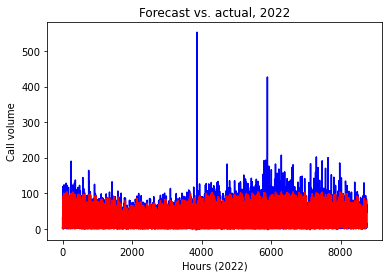

In [258]:
plt.plot(data_2021['CaseID'].values, c='b')
plt.plot(forecast_unnorm, c='r')
plt.title("Forecast vs. actual, 2022")
plt.xlabel("Hours (2022)")
plt.ylabel("Call volume")
plt.savefig("figures/Forecast_2022", dpi=300)
plt.show();

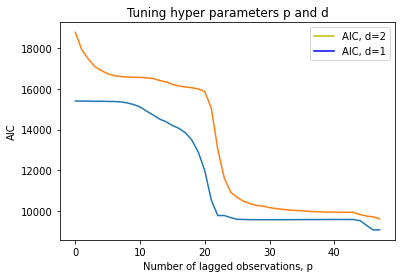

In [259]:
plt.plot(aic_array)
plt.plot([], c='y', label='AIC, d=2')
plt.plot([], c='b', label='AIC, d=1')
plt.xlabel("Number of lagged observations, p")
plt.ylabel("AIC")
plt.title("Tuning hyper parameters p and d")
plt.legend()
plt.savefig('figures/ARIMA_AIC', dpi=300)
plt.show();

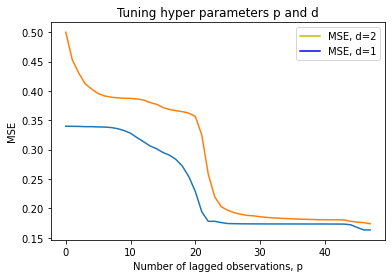

In [345]:
plt.plot(mse_array)
plt.plot([], c='y', label='MSE, d=2')
plt.plot([], c='b', label='MSE, d=1')
plt.xlabel("Number of lagged observations, p")
plt.ylabel("MSE")
plt.title("Tuning hyper parameters p and d")
plt.legend()
plt.savefig('figures/ARIMA_RMSE', dpi=300)
plt.show();

In [261]:
rmse = np.sqrt(mean_squared_error(forecast_unnorm, data_2022['CaseID']))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 16.917


In [262]:
r2 = r2_score(forecast_unnorm, data_2022['CaseID'])
print('Test R^2: %.3f' % r2)

Test R^2: 0.608


In [263]:
np.max(np.abs((forecast_unnorm - data_2022['CaseID'].values)))

218.02974212791744

<AxesSubplot:>

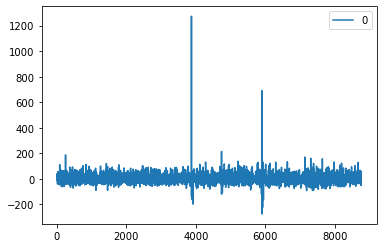

In [264]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()

<AxesSubplot:ylabel='Density'>

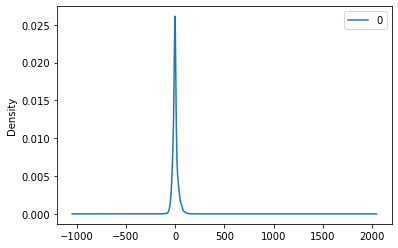

In [265]:
residuals.plot(kind='kde')

In [266]:
residuals.describe()

,0
count,8760.000000
mean,0.026359
std,30.587380
min,-274.220338
25%,-12.927860
50%,-2.203930
75%,8.440251
max,1273.656720


### Do it for all years

In [285]:
# Tuning all years with normalization and outlier clipping
# This code takes 1-1.5 hours to run if I include hyperparameter tuning
# Commenting that out and just using the optimal order, because when I've run it, there's no difference across models

all_years = np.unique(full_hourly_count['Year'].values)
full_forecast = np.array([])
orders = []
rmse_array = []
r2_array = []
for i in range(len(all_years)-1):
    year = all_years[i]
    print(year)
    next_year = all_years[i+1]
    current_year_data = full_hourly_count[full_hourly_count['Year']==year]['CaseID_norm'].values
    
    next_year_length = len(full_hourly_count[full_hourly_count['Year']==next_year])
    next_year_data = full_hourly_count[full_hourly_count['Year']==next_year]['CaseID'].values
    
    model = ARIMA(current_year_data, order=optimal_order)
    model_fit = model.fit()
#     print(model_fit.summary())
    forecast = model_fit.predict(end=next_year_length-1)
    
    
#     aic_array, mse_array, optimal_order, forecast = tune_arima_hyperparams(data=current_year_data, forecast_length=next_year_length-1, p=24, d=2)

    
#     aic_array, mse_array, optimal_order, forecast = tune_arima_hyperparams(data=clipped_current_year_data, forecast_length=next_year_length-1, p=24, d=2)
    
    # Need to select right scaler
    
    curr_scaler = scaler_dict['scaler'][np.argmax(np.unique(full_hourly_count['Year'].values)==year)]
    forecast_unnorm = curr_scaler.inverse_transform(forecast.reshape(-1,1)).reshape(-1)
    rmse = np.sqrt(mean_squared_error(next_year_data, forecast_unnorm))
    print('Test RMSE: %.3f' % rmse)
    r2 = r2_score(next_year_data, forecast_unnorm)
    print('Test R^2: %.3f' % r2)
    orders.append(optimal_order)
    rmse_array.append(rmse)
    r2_array.append(r2)
    full_forecast = np.concatenate([full_forecast, forecast_unnorm])

2009
Test RMSE: 4.602
Test R^2: 0.461
2010
Test RMSE: 5.314
Test R^2: 0.459
2011
Test RMSE: 5.204
Test R^2: 0.489
2012
Test RMSE: 6.452
Test R^2: 0.435
2013
Test RMSE: 7.956
Test R^2: 0.480
2014
Test RMSE: 8.310
Test R^2: 0.560
2015
Test RMSE: 13.324
Test R^2: 0.459
2016
Test RMSE: 14.112
Test R^2: 0.548
2017


/Users/jaredschober/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test RMSE: 14.845
Test R^2: 0.623
2018
Test RMSE: 15.255
Test R^2: 0.681
2019
Test RMSE: 16.480
Test R^2: 0.686
2020


/Users/jaredschober/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test RMSE: 19.020
Test R^2: 0.659
2021
Test RMSE: 16.917
Test R^2: 0.727


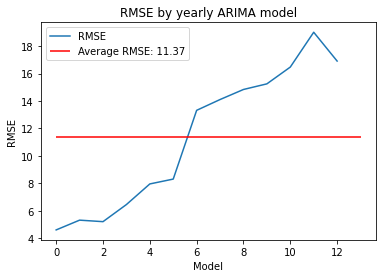

In [340]:
# Calculate and plot average RMSE across models 
plt.plot(rmse_array, label='RMSE')
plt.xlabel("Model")
plt.ylabel("RMSE")
plt.title("RMSE by yearly ARIMA model")
average_rmse = np.mean(rmse_array)
plt.hlines(average_rmse, xmin=0, xmax=13, colors='r', label='Average RMSE: %.2f' % average_rmse)
plt.legend()
plt.savefig("figures/ARIMA_model_RMSE", dpi=300)
plt.show();

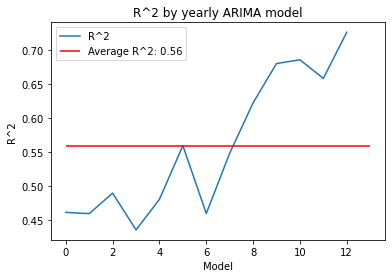

In [341]:
# Calculate and plot average R^2 across models 
plt.plot(r2_array, label='R^2')
plt.xlabel("Model")
plt.ylabel("R^2")
plt.title("R^2 by yearly ARIMA model")
average_r2 = np.mean(r2_array)
plt.hlines(average_r2, xmin=0, xmax=13, colors='r', label='Average R^2: %.2f' % average_r2)
plt.legend()
plt.show();

In [342]:
# Calculate average max residual across models
max_resid_array = []
count = len(full_hourly_count[full_hourly_count['Year']==2009])
for i in range(len(np.unique(full_hourly_count['Year']))-2):
    increment = len(full_hourly_count[full_hourly_count['Year']==np.unique(full_hourly_count['Year'])[i+1]])
    curr_data = full_hourly_count.iloc[count:count+increment]['CaseID'].values
    max_resid = np.max(np.abs(curr_data - full_forecast[count:count+increment]))
    max_resid_array.append(max_resid)
    count += increment
    
print(np.mean(max_resid_array))

161.37652546254927


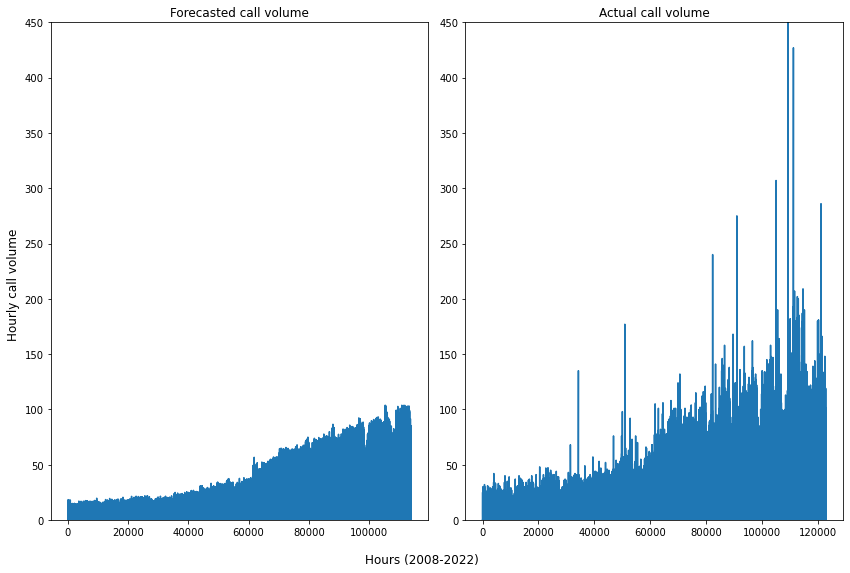

In [347]:
fig, ax = plt.subplots(1,2, figsize=(12, 8))
ax[0].plot(full_forecast)
ax[0].set_title("Forecasted call volume")
ax[1].plot(full_hourly_count['CaseID'].values)
ax[1].set_title("Actual call volume")
fig.supxlabel("Hours (2008-2022)")
fig.supylabel("Hourly call volume")
ax[0].set_ylim(0,450)
ax[1].set_ylim(0,450)
plt.tight_layout()
plt.savefig('figures/ARIMA_forecast_vs_actual', dpi=300)
plt.show();